## Setting the environment


In [ ]:
# Mounting google drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Importing essential libraries and functions

import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from numpy import array
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM,SimpleRNN, Conv1D, MaxPooling1D, Dense, Dropout, Flatten
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score


## Loading dataset


In [ ]:
# Importing dataset

df = pd.read_csv('/content/drive/My Drive/Just Dance Dataset/justDanceAnalysis.csv')


In [ ]:
# Dataset exploration

df.shape

(1521166, 23)

In [ ]:
df.head(5)

,annotationID,dimension,concept,commentID,originalText,expandedText,sentiment,likes,dateComment,mainComment,...,channelID,channelTitle,videoID,videoTitle,dateVideo,viewsVideo,likesVideo,dislikesVideo,totalCommentsVideo,descriptionVideo
0,540774,H-QOL,Energy,UgwRJtk82TL32hm4eCl4AaABAg,At the chorus just like PRITTIs dance ...,at the chorus just like prittis dance,Positive,1,2017-12-14,Main,...,UCPx5cLBEuxgI-6AwMGGChBw,Redoo,wc3wUMPFfbI,Boombayah by BLACKPINK | Just Dance 2018 | Fan...,2017-11-20,6269036,92508,6887,3604,HEY EVERYONE!!! :D BLACKPINK is in your Just D...
1,540775,H-QOL,Positive feelings,UgwRJtk82TL32hm4eCl4AaABAg,At the chorus just like PRITTIs dance ...,at the chorus just like prittis dance,Positive,1,2017-12-14,Main,...,UCPx5cLBEuxgI-6AwMGGChBw,Redoo,wc3wUMPFfbI,Boombayah by BLACKPINK | Just Dance 2018 | Fan...,2017-11-20,6269036,92508,6887,3604,HEY EVERYONE!!! :D BLACKPINK is in your Just D...
2,528601,H-QOL,Positive feelings,UgwPoAyj3B1oL_oKZ3l4AaABAg,omg its so realistic I love your channel,oh my god its so realistic i love your channel,Positive,0,2018-03-29,Main,...,UCPx5cLBEuxgI-6AwMGGChBw,Redoo,RzvXipjAcmI,Échame La Culpa by Luis Fonsi ft. Demi Lovato ...,2018-02-17,2711746,14913,1005,455,HEY EVERYONE!! This year I promise to provide ...
3,528602,H-QOL,Self-esteem,UgwPoAyj3B1oL_oKZ3l4AaABAg,omg its so realistic I love your channel,oh my god its so realistic i love your channel,Positive,0,2018-03-29,Main,...,UCPx5cLBEuxgI-6AwMGGChBw,Redoo,RzvXipjAcmI,Échame La Culpa by Luis Fonsi ft. Demi Lovato ...,2018-02-17,2711746,14913,1005,455,HEY EVERYONE!! This year I promise to provide ...
4,512383,H-QOL,Learning,UgwNiyb-B356nqHRSPF4AaABAg,No. I was just saying. I used to think When I ...,no i was just saying i used to think when i gr...,Negative,0,2012-09-17,Main,...,UCNUx8bzoHniTZ3hp-UfA4OQ,farfromsubtle,sPPpZEOtmjo,BEST Game Trailer EVER! - Just Dance 2 - Video...,2010-06-21,89560,936,40,156,The guys dont know what theyre in for... Join ...


In [ ]:
# Checking for missing values

df.isnull().values.any()

True

In [ ]:
df=df.dropna()
print(len(df))

1466124


In [ ]:
# Checking for missing values

df.isnull().values.any()

False

<Axes: xlabel='sentiment', ylabel='count'>

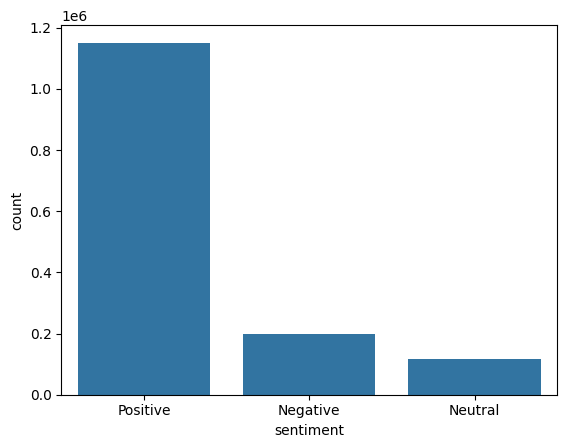

In [ ]:
# Let's observe distribution of positive , neutral , negative sentiments in dataset

import seaborn as sns
sns.countplot(x='sentiment', data=df)

In [ ]:
#Oversampling
from sklearn.utils import resample

# Separate majority and minority classes
df_majority = df[df.sentiment == 'Positive']
df_minority_neg = df[df.sentiment == 'Negative']
df_minority_neu = df[df.sentiment == 'Neutral']

# Upsample minority classes
df_minority_neg_upsampled = resample(df_minority_neg,
                                     replace=True,     # sample with replacement
                                     n_samples=len(df_majority),    # to match majority class
                                     random_state=123) # reproducible results

df_minority_neu_upsampled = resample(df_minority_neu,
                                     replace=True,     # sample with replacement
                                     n_samples=len(df_majority),    # to match majority class
                                     random_state=123) # reproducible results

# Combine majority class with upsampled minority classes
df_upsampled = pd.concat([df_majority, df_minority_neg_upsampled, df_minority_neu_upsampled])

# Display new class counts
print(df_upsampled.sentiment.value_counts())

sentiment
Positive    1150592
Negative    1150592
Neutral     1150592
Name: count, dtype: int64


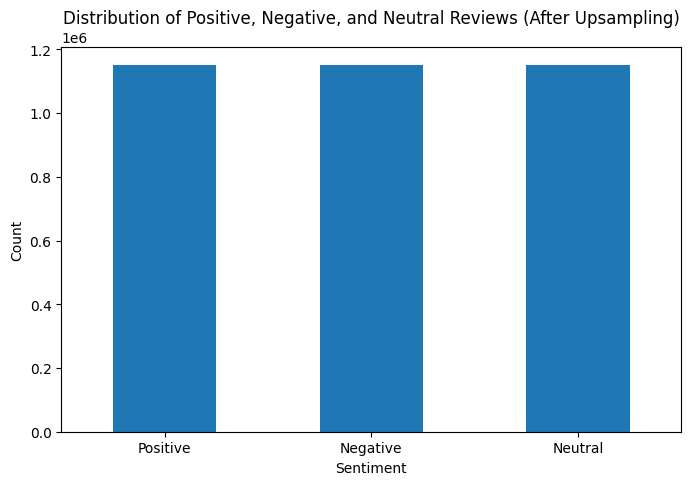

In [ ]:
# Plotting the distribution
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 5))
df_upsampled['sentiment'].value_counts().plot(kind='bar')
plt.title('Distribution of Positive, Negative, and Neutral Reviews (After Upsampling)')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

In [ ]:
# Downsample majority class
df_majority_downsampled = resample(df_majority,
                                   replace=False,    # sample without replacement
                                   n_samples=len(df_minority_neg),     # to match minority class
                                   random_state=123) # reproducible results

# Combine minority class with downsampled majority class
df_downsampled = pd.concat([df_majority_downsampled, df_minority_neg, df_minority_neu])

# Display new class counts
print(df_downsampled.sentiment.value_counts())

sentiment
Positive    198831
Negative    198831
Neutral     116701
Name: count, dtype: int64


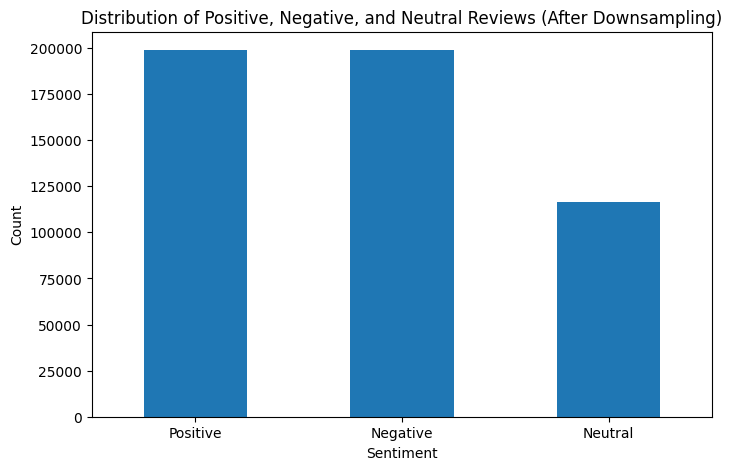

In [ ]:
# Plotting the distribution
plt.figure(figsize=(8, 5))
df_downsampled['sentiment'].value_counts().plot(kind='bar')
plt.title('Distribution of Positive, Negative, and Neutral Reviews (After Downsampling)')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

## Data Preprocessing


In [ ]:
df["originalText"][150]

'Where the exclusive Songs?!😭😭😭😭'

In [ ]:
import re
import emoji
import nltk

# Download the 'punkt' resource
nltk.download('punkt')

# You may also want to download the 'stopwords' and 'wordnet' resources
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
def preprocess_text(text):
    # Convert emojis to text
    text = emoji.demojize(text)

    # Convert to lowercase
    text = text.lower()

    # Replace punctuation with a space (or remove it)
    text = re.sub(r'[^\w\s]', '', text)

    # Tokenize text
    tokens = word_tokenize(text)

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]

    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    # Join tokens back to a string
    return ' '.join(tokens)

# Apply the preprocessing to the 'originalText' column
df['cleanedText'] = df['originalText'].apply(preprocess_text)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
df["cleanedText"][150]

'exclusive songsloudly_crying_faceloudly_crying_faceloudly_crying_faceloudly_crying_face'

In [ ]:
!pip install emoji


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 431.4/431.4 kB 9.6 MB/s eta 0:00:00


In [ ]:
TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    '''Removes HTML tags: replaces anything between opening and closing <> with empty space'''

    return TAG_RE.sub('', text)

In [ ]:
def preprocess_text(sen):
    '''Cleans text data up, leaving only 2 or more char long non-stepwords composed of A-Z & a-z only
    in lowercase'''

    sentence = sen.lower()

    # Remove html tags
    sentence = remove_tags(sentence)

    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)  # When we remove apostrophe from the word "Mark's", the apostrophe is replaced by an empty space. Hence, we are left with single character "s" that we are removing here.

    # Remove multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)  # Next, we remove all the single characters and replace it by a space which creates multiple spaces in our text. Finally, we remove the multiple spaces from our text as well.

    # Remove Stopwords
    pattern = re.compile(r'\b(' + r'|'.join(stopwords.words('english')) + r')\b\s*')
    sentence = pattern.sub('', sentence)

    return sentence

In [ ]:
# Calling preprocessing_text function on movie_reviews

X = []
sentences = list(df['cleanedText'])
for sen in sentences:
    X.append(preprocess_text(sen))

In [ ]:
# Sample cleaned up

X[150]

'lol imagine first thing alien see hahahahaha'

## Preparing embedding layer and
# Model Training with:



##Simple Neural Network


In [ ]:
# Keep only the necessary columns
data = df[['expandedText', 'sentiment']]


In [ ]:
# Drop duplicates
data.drop_duplicates(subset='expandedText', inplace=True, keep='first')


<ipython-input-25-a6327d11f275>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.drop_duplicates(subset='expandedText', inplace=True, keep='first')


In [ ]:

# Convert sentiment to numerical labels
sentiment_label = {'Positive': 1, 'Neutral': 2, 'Negative': 0}
data['sentiment_num'] = data['sentiment'].map(sentiment_label)


<ipython-input-26-c0334de9225c>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['sentiment_num'] = data['sentiment'].map(sentiment_label)


In [ ]:

# Split the data into training and test sets
X = data['expandedText'].values
y = data['sentiment_num'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:

# Tokenize the text data
tokenizer = Tokenizer(num_words=5000, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index


In [ ]:
# Convert text to sequences
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)


In [ ]:
# Pad sequences to ensure uniform input length
max_length = 100
X_train_pad = pad_sequences(X_train_seq, maxlen=max_length, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_length, padding='post', truncating='post')


In [ ]:
# Define the Simple RNN model
model = Sequential()
model.add(Embedding(input_dim=5000, output_dim=128, input_length=max_length))
model.add(SimpleRNN(64, return_sequences=True))
model.add(Dropout(0.5))
model.add(SimpleRNN(64))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
# Train the model
history = model.fit(X_train_pad, y_train, epochs=5, validation_data=(X_test_pad, y_test), batch_size=64)


Epoch 1/5
3258/3258 ━━━━━━━━━━━━━━━━━━━━ 85s 24ms/step - accuracy: 0.6485 - loss: 0.9050 - val_accuracy: 0.6551 - val_loss: 0.8825
Epoch 2/5
3258/3258 ━━━━━━━━━━━━━━━━━━━━ 136s 23ms/step - accuracy: 0.6556 - loss: 0.8839 - val_accuracy: 0.6551 - val_loss: 0.8826
Epoch 3/5
3258/3258 ━━━━━━━━━━━━━━━━━━━━ 80s 23ms/step - accuracy: 0.6551 - loss: 0.8848 - val_accuracy: 0.6551 - val_loss: 0.8826
Epoch 4/5
3258/3258 ━━━━━━━━━━━━━━━━━━━━ 81s 23ms/step - accuracy: 0.6559 - loss: 0.8836 - val_accuracy: 0.6551 - val_loss: 0.8838
Epoch 5/5
3258/3258 ━━━━━━━━━━━━━━━━━━━━ 82s 23ms/step - accuracy: 0.6565 - loss: 0.8834 - val_accuracy: 0.6551 - val_loss: 0.8855


In [ ]:
# Evaluate the model
y_pred = model.predict(X_test_pad)
y_pred_rnn = np.argmax(y_pred, axis=1)


1629/1629 ━━━━━━━━━━━━━━━━━━━━ 15s 9ms/step


In [ ]:
# Print accuracy and confusion matrix
print('Accuracy:', accuracy_score(y_test, y_pred_rnn))
print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred_rnn))

Accuracy: 0.6550638983766358
Confusion Matrix:
[[    0  8353     0]
 [    0 34138     0]
 [    0  9623     0]]


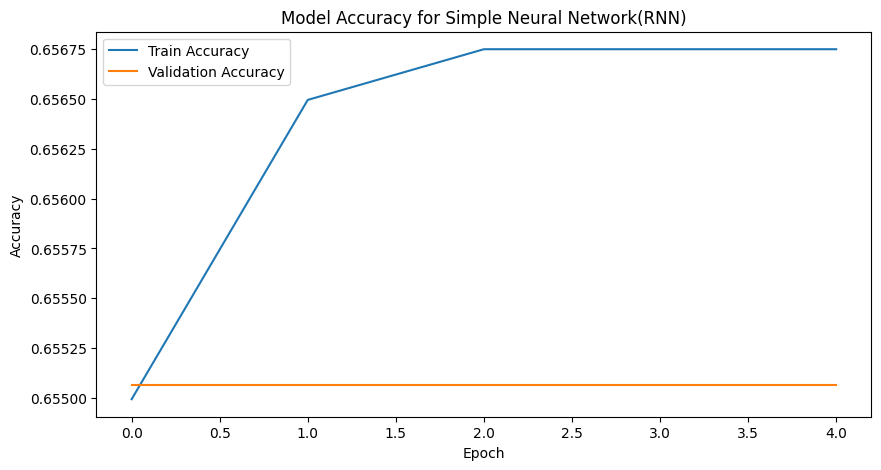

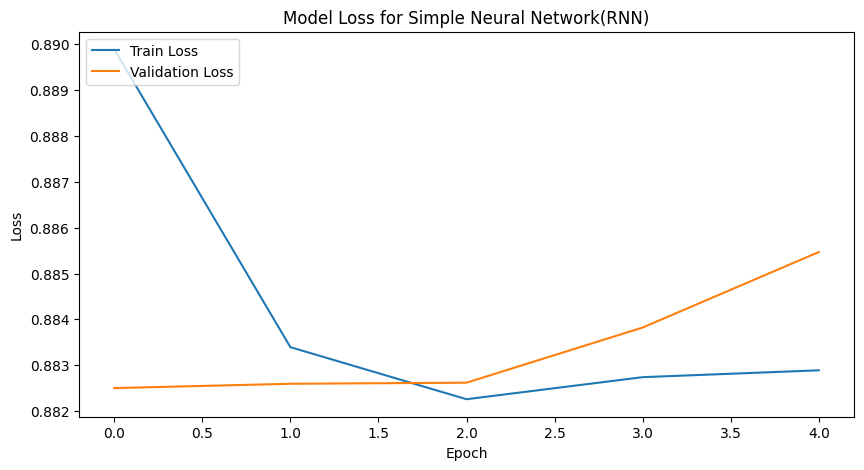

In [ ]:
import matplotlib.pyplot as plt

# Plot model accuracy
plt.figure(figsize=(10, 5))

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy for Simple Neural Network(RNN)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.show()

# Plot model loss
plt.figure(figsize=(10, 5))

# Plot training & validation loss values
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss for Simple Neural Network(RNN)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper left')
plt.show()


## Convolutional Neural Network.


In [ ]:
# Keep only the necessary columns
data = df[['expandedText', 'sentiment']]



In [ ]:

# Drop duplicates
data.drop_duplicates(subset='expandedText', inplace=True, keep='first')


<ipython-input-38-a6327d11f275>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.drop_duplicates(subset='expandedText', inplace=True, keep='first')


In [ ]:

# Convert sentiment to numerical labels
sentiment_label = {'Positive': 1, 'Neutral': 2, 'Negative': 0}
data['sentiment_num'] = data['sentiment'].map(sentiment_label)


<ipython-input-39-c0334de9225c>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['sentiment_num'] = data['sentiment'].map(sentiment_label)


In [ ]:

# Split the data into training and test sets
X = data['expandedText'].values
y = data['sentiment_num'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:

# Tokenize the text data
tokenizer = Tokenizer(num_words=5000, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index


In [ ]:

# Convert text to sequences
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)


In [ ]:

# Pad sequences to ensure uniform input length
max_length = 100
X_train_pad = pad_sequences(X_train_seq, maxlen=max_length, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_length, padding='post', truncating='post')


In [ ]:

# Define the CNN model
model = Sequential()
model.add(Embedding(input_dim=5000, output_dim=128, input_length=max_length))
model.add(Conv1D(128, kernel_size=5, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.5))
model.add(Conv1D(128, kernel_size=5, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:

# Train the model
history = model.fit(X_train_pad, y_train, epochs=5, validation_data=(X_test_pad, y_test), batch_size=64)


Epoch 1/5
3258/3258 ━━━━━━━━━━━━━━━━━━━━ 25s 6ms/step - accuracy: 0.8365 - loss: 0.4487 - val_accuracy: 0.9254 - val_loss: 0.2337
Epoch 2/5
3258/3258 ━━━━━━━━━━━━━━━━━━━━ 31s 4ms/step - accuracy: 0.9230 - loss: 0.2493 - val_accuracy: 0.9316 - val_loss: 0.2178
Epoch 3/5
3258/3258 ━━━━━━━━━━━━━━━━━━━━ 21s 5ms/step - accuracy: 0.9305 - loss: 0.2262 - val_accuracy: 0.9340 - val_loss: 0.2163
Epoch 4/5
3258/3258 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.9343 - loss: 0.2136 - val_accuracy: 0.9347 - val_loss: 0.2192
Epoch 5/5
3258/3258 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.9388 - loss: 0.1991 - val_accuracy: 0.9340 - val_loss: 0.2172


In [ ]:

# Evaluate the model
y_pred = model.predict(X_test_pad)
y_pred_cnn = np.argmax(y_pred, axis=1)


1629/1629 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step


In [ ]:

# Print accuracy and confusion matrix
print('Accuracy:', accuracy_score(y_test, y_pred_cnn))
print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred_cnn))

Accuracy: 0.9339524887746095
Confusion Matrix:
[[ 6884  1065   404]
 [  651 33040   447]
 [  319   556  8748]]


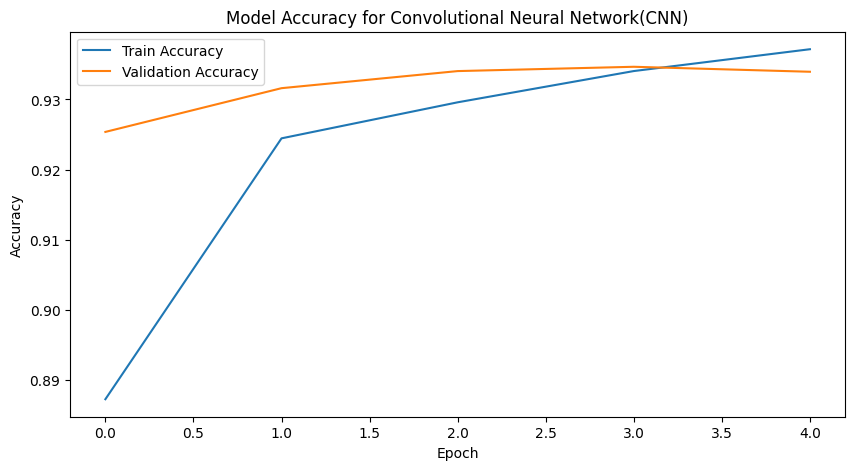

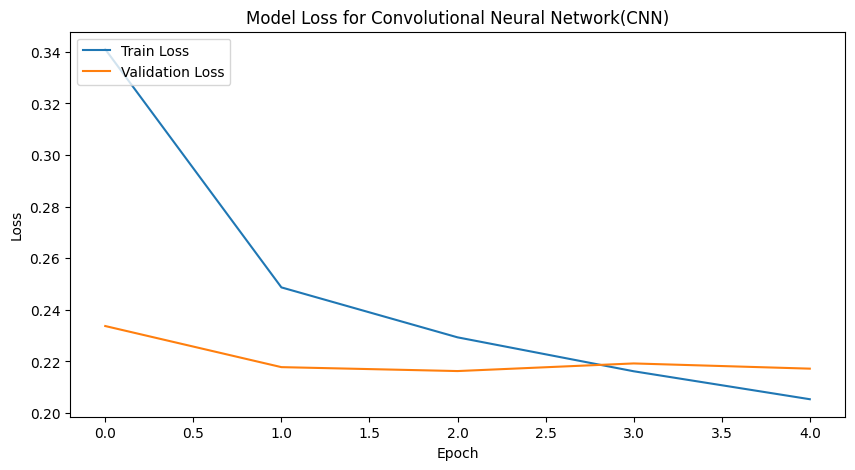

In [ ]:
import matplotlib.pyplot as plt

# Plot model accuracy
plt.figure(figsize=(10, 5))

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy for Convolutional Neural Network(CNN)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.show()

# Plot model loss
plt.figure(figsize=(10, 5))

# Plot training & validation loss values
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss for Convolutional Neural Network(CNN)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper left')
plt.show()


## Recurrent Neural Network (LSTM)

In [ ]:
# Keep only the necessary columns
data = df[['expandedText', 'sentiment']]

In [ ]:
# Drop duplicates
data.drop_duplicates(subset='expandedText', inplace=True, keep='first')


<ipython-input-50-a6327d11f275>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.drop_duplicates(subset='expandedText', inplace=True, keep='first')


In [ ]:

# Convert sentiment to numerical labels
sentiment_label = {'Positive': 1, 'Neutral': 2, 'Negative': 0}
data['sentiment_num'] = data['sentiment'].map(sentiment_label)


<ipython-input-51-c0334de9225c>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['sentiment_num'] = data['sentiment'].map(sentiment_label)


In [ ]:

# Split the data into training and test sets
X = data['expandedText'].values
y = data['sentiment_num'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:

# Tokenize the text data
tokenizer = Tokenizer(num_words=5000, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index


In [ ]:

# Convert text to sequences
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)


In [ ]:

# Pad sequences to ensure uniform input length
max_length = 100
X_train_pad = pad_sequences(X_train_seq, maxlen=max_length, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_length, padding='post', truncating='post')


In [ ]:

# Define the LSTM model
model = Sequential()
model.add(Embedding(input_dim=5000, output_dim=128, input_length=max_length))
model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(64))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:

# Train the model
history = model.fit(X_train_pad, y_train, epochs=5, validation_data=(X_test_pad, y_test), batch_size=64)


Epoch 1/5
3258/3258 ━━━━━━━━━━━━━━━━━━━━ 47s 12ms/step - accuracy: 0.6559 - loss: 0.8903 - val_accuracy: 0.6551 - val_loss: 0.8822
Epoch 2/5
3258/3258 ━━━━━━━━━━━━━━━━━━━━ 40s 12ms/step - accuracy: 0.6747 - loss: 0.8334 - val_accuracy: 0.9132 - val_loss: 0.2717
Epoch 3/5
3258/3258 ━━━━━━━━━━━━━━━━━━━━ 41s 12ms/step - accuracy: 0.9241 - loss: 0.2506 - val_accuracy: 0.9366 - val_loss: 0.2079
Epoch 4/5
3258/3258 ━━━━━━━━━━━━━━━━━━━━ 49s 15ms/step - accuracy: 0.9402 - loss: 0.2002 - val_accuracy: 0.9378 - val_loss: 0.2033
Epoch 5/5
3258/3258 ━━━━━━━━━━━━━━━━━━━━ 74s 12ms/step - accuracy: 0.9447 - loss: 0.1845 - val_accuracy: 0.9402 - val_loss: 0.1977


In [ ]:

# Evaluate the model
y_pred = model.predict(X_test_pad)
y_pred_lstm = np.argmax(y_pred, axis=1)


1629/1629 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step


In [ ]:

# Print accuracy and confusion matrix
print('Accuracy:', accuracy_score(y_test, y_pred_lstm))
print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred_lstm))

Accuracy: 0.9401504394212687
Confusion Matrix:
[[ 7092   790   471]
 [  580 33072   486]
 [  309   483  8831]]


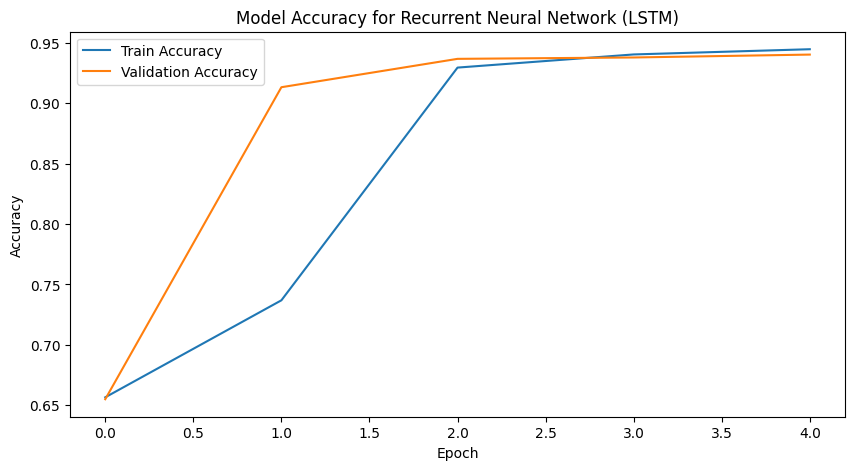

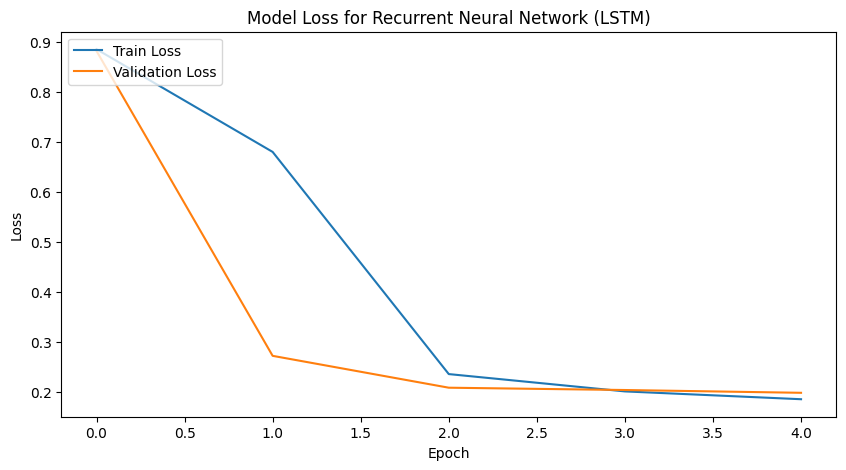

In [ ]:
import matplotlib.pyplot as plt

# Plot model accuracy
plt.figure(figsize=(10, 5))

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy for Recurrent Neural Network (LSTM)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.show()

# Plot model loss
plt.figure(figsize=(10, 5))

# Plot training & validation loss values
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss for Recurrent Neural Network (LSTM)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper left')
plt.show()

In [ ]:
from transformers import BertTokenizer, TFBertForSequenceClassification
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize the input text for BERT
def encode_texts(texts):
    return tokenizer(
        texts.tolist(),
        max_length=128,
        padding=True,
        truncation=True,
        return_tensors="tf"
    )

X_train_enc = encode_texts(X_train)
X_test_enc = encode_texts(X_test)

# Convert labels to TensorFlow tensors
y_train_tf = tf.convert_to_tensor(y_train)
y_test_tf = tf.convert_to_tensor(y_test)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
# Load the pre-trained BERT model for sequence classification
model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)

# Compile the model
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

# Train the model
history = model.fit(
    X_train_enc['input_ids'],
    y_train_tf,
    epochs=3,
    batch_size=16,
    validation_data=(X_test_enc['input_ids'], y_test_tf)
)

# Evaluate the model
y_pred = model.predict(X_test_enc['input_ids']).logits
y_pred_classes = tf.argmax(y_pred, axis=1)

# Print accuracy and confusion matrix
print('Accuracy:', accuracy_score(y_test, y_pred_classes))
print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred_classes))


All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3
 5312/13029 [===========>..................] - ETA: 53:36 - loss: 0.8846 - accuracy: 0.6598

In [ ]:
import matplotlib.pyplot as plt

# Plot model accuracy
plt.figure(figsize=(10, 5))

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy for BERT')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.show()

# Plot model loss
plt.figure(figsize=(10, 5))

# Plot training & validation loss values
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss for BERT')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper left')
plt.show()

In [ ]:
# Save LSTM model
lstm_model.save(f'/content/drive/My Drive/Just Dance Dataset/lstm_model_acc_{round(lstm_score[1], 3)}.h5', save_format='h5')
# Save CNN model
cnn_model.save(f'/content/drive/My Drive/Just Dance Dataset/cnn_model_acc_{round(cnn_score[1], 3)}.h5', save_format='h5')
# Save RNN model
rnn_model.save(f'/content/drive/My Drive/Just Dance Dataset/rnn_model_acc_{round(rnn_score[1], 3)}.h5', save_format='h5')
# Save BERT model and tokenizer
bert_model.save_pretrained(f"./bert_model_acc_{round(bert_score, 3)}")
tokenizer.save_pretrained(f"./bert_tokenizer")


In [ ]:
from sklearn.metrics import classification_report

# Assuming you have y_pred and y_pred_classes from BERT
print("Classification Report for BERT:")
print(classification_report(y_test, y_pred_classes, target_names=['Negative', 'Neutral', 'Positive']))

# Compare with RNN, LSTM, CNN results
print("Classification Report for RNN:")
# Assuming you have y_pred_rnn from your RNN model
print(classification_report(y_test, y_pred_rnn, target_names=['Negative', 'Neutral', 'Positive']))
print("Classification Report for CNN:")
# Assuming you have y_pred_cnn from your CNN model
print(classification_report(y_test, y_pred_cnn, target_names=['Negative', 'Neutral', 'Positive']))
print("Classification Report for LSTM:")
# Assuming you have y_pred_lstm from your LSTM model
print(classification_report(y_test, y_pred_lstm, target_names=['Negative', 'Neutral', 'Positive']))


